




# Projekt i deep learning 
## Ensembelmodell av flera CNN-modeller











Johannes Hedström 

2023- 06 - 01







Umeå Universitet







# Bakgrund

Ett sätt att följa spelare på fotbollsplanen är att låta AI läsa av videos och bilder för att identidfiera vilka som faktiskt är spelarna och sedan göra beräkningar för att se hur respektive spelare rör sig på planen. 

Den här uppsatsen kommer att hålla sig till att göra en ensembelmodell som ska kunna identifiera spelare från bilderna så bra som möjligt. Ett sätt att göra modeller som pricksäkert ska kunna identifiera mönster på bilder för att göra prediktioner är CNN-modeller(Convolutional Neural Network), det finns mycket tidigare forskning inom detta ämne och många olika modeller har tränats. Så istället för att "skapa hjulet" som redan finns så kommer modellerna som används till stor del att vara förtränade modeller för att sedan slå ihop prediktionerna från respektive modell till en slutgiltig prediktion för spelarna på bilderna.

















# Data 

Datamaterialet består av 512 st bilder som är tagna på planen fotbollsmatcher, på bilderna så finns olika antal spelare från 2 olika lag(allt från målvakt till forward) samt domaren. Tillgången till datamaterialet är genom Kaggle.

Bilderna har även en pixel-nivåmask vilket indikerar på spelarnas position på bilden


En bild kan exempelvis se ut såhär :



In [289]:
# Läser in paket
import json
import tensorflow as tf
import os
import cv2
import pandas as pd
import numpy as np
import PIL
import keras

from PIL import Image
# from tensorflow import keras
# from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout, Input, Concatenate, Lambda, GlobalAveragePooling2D
from tensorflow.keras.utils  import to_categorical

#print('Keras version:',tf.keras.__version__)

# Helper libraries

import sklearn
from   sklearn.model_selection import train_test_split


#earlystopping
from keras.callbacks import EarlyStopping

# importerar funktioner för att skapa förväxlingsmatriser
from sklearn.metrics import   ConfusionMatrixDisplay, confusion_matrix

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [290]:
train = "../input/sports-image-classification/dataset/train"
test = "../input/sports-image-classification/dataset/test"
labels = pd.read_csv('/kaggle/input/sports-image-classification/dataset/train.csv')
labels_test=pd.read_csv('/kaggle/input/sports-image-classification/dataset/test.csv')

In [291]:
print(labels.head(5))

         image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket


In [292]:
print(labels['label'].value_counts())

Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: label, dtype: int64


In [293]:
# Group the dataframe by 'label' and select the first image ID for each unique label
df_unique = labels.groupby('label')['image_ID'].first().reset_index()

print(df_unique)

classes = df_unique['label']

       label        image_ID
0  Badminton  7c225f7b61.jpg
1    Cricket  cfd2c28c74.jpg
2     Karate  c7657216ce.jpg
3     Soccer  9ec9dbc59a.jpg
4   Swimming  da4d3e218c.jpg
5     Tennis  e06a27208d.jpg
6  Wrestling  772648a478.jpg


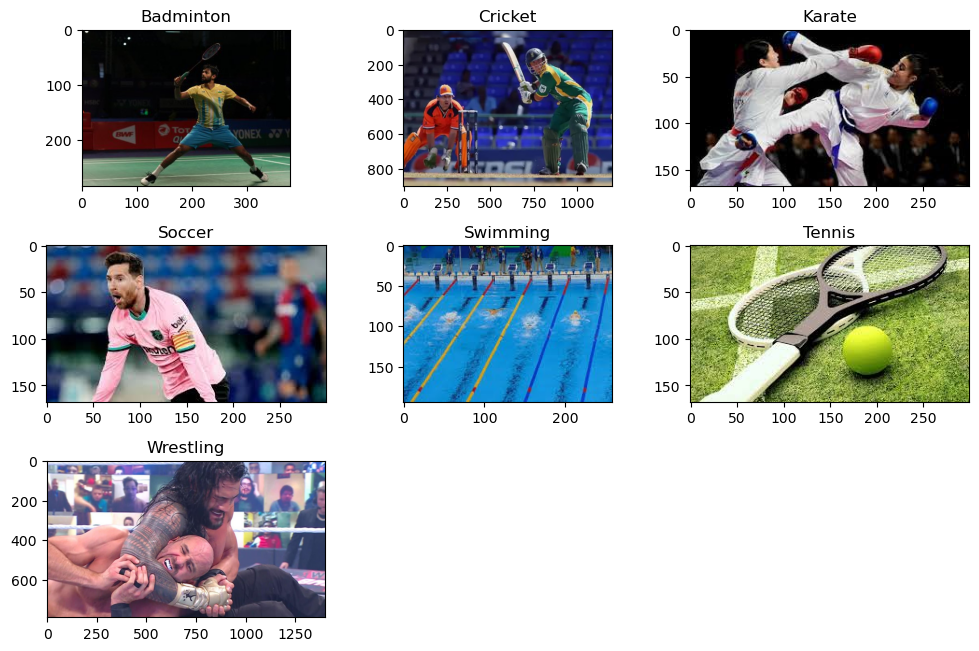

In [294]:


# Plotting
fig = plt.figure(figsize=(10, 15))
k = 0

for sport_idx, sport in enumerate(df_unique['image_ID']):
    k = k + 1
    plt.subplot(7, 3, k)

    # Get the corresponding label for the current image
    label = df_unique.loc[df_unique['image_ID'] == sport, 'label'].values[0]

    # Load and plot the image
    image_path = '/kaggle/input/sports-image-classification/dataset/train/' + sport  # Replace with your actual image directory
    image = Image.open(image_path)
    plt.title(label)
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [295]:
validation_split = 0.6
idxs = np.random.permutation(range(len(labels))) < validation_split*len(labels)

train_labels = labels[idxs]
val_labels = labels[~idxs]

validation_split = 0.7
idxs2 = np.random.permutation(range(len(val_labels))) < validation_split*len(val_labels)

test_label = val_labels[~idxs2]
print(len(train_labels), len(val_labels), len(test_label))

4937 3290 987


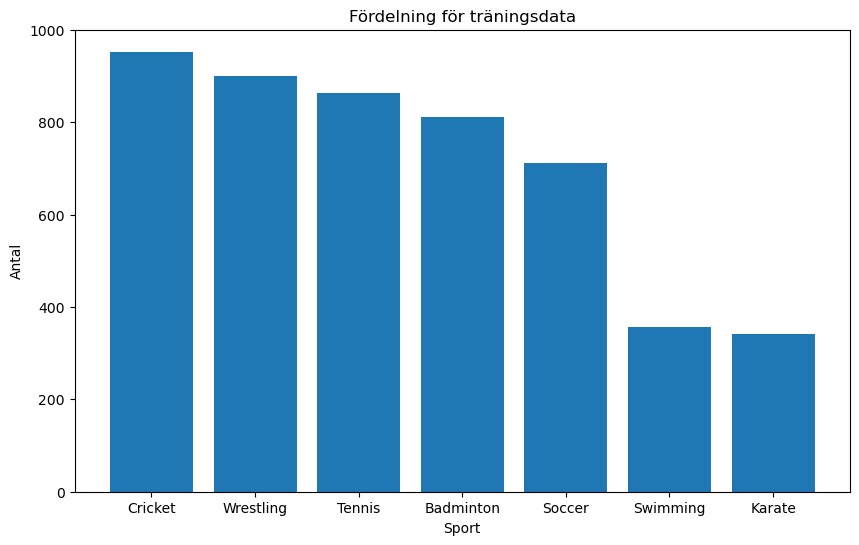

In [296]:

# Plockar ut labels
sporter = train_labels["label"].value_counts()

# Skapar plot och ger den axelnamn
plt.figure(figsize=(10, 6))
plt.bar(sporter.index, sporter.values)


plt.xlabel("Sport")
plt.ylabel("Antal")
plt.title("Fördelning för träningsdata")


plt.show()

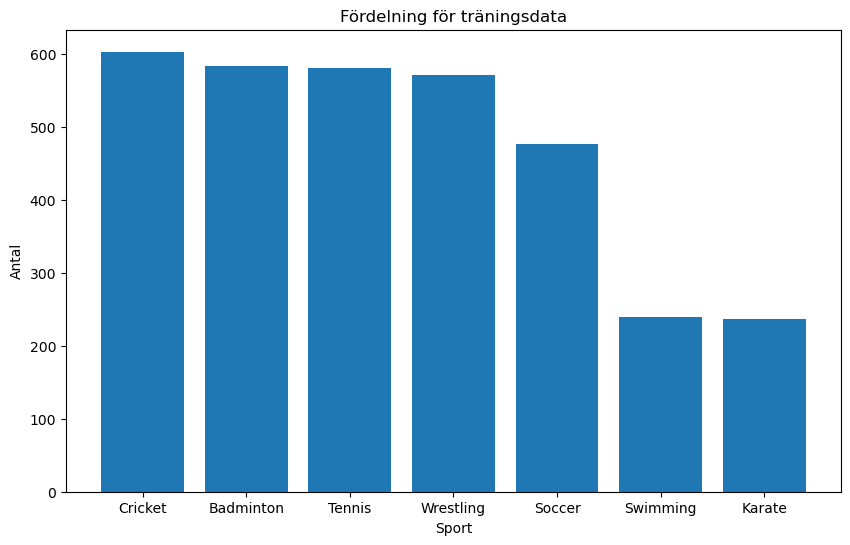

In [326]:
# Plockar ut labels
sporter = val_labels["label"].value_counts()

# Skapar plot och ger den axelnamn
plt.figure(figsize=(10, 6))
plt.bar(sporter.index, sporter.values)


plt.xlabel("Sport")
plt.ylabel("Antal")
plt.title("Fördelning för träningsdata")


plt.show()

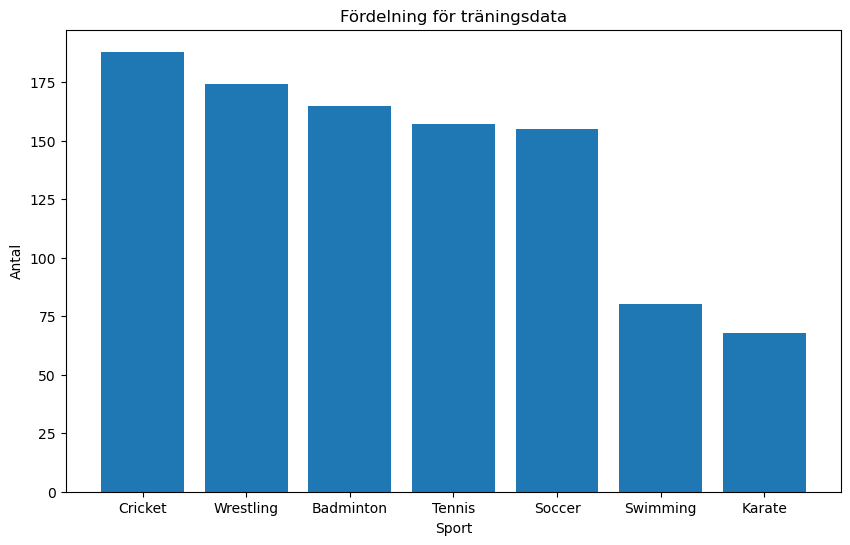

In [328]:
# Plockar ut labels
sporter = test_label["label"].value_counts()

# Skapar plot och ger den axelnamn
plt.figure(figsize=(10, 6))
plt.bar(sporter.index, sporter.values)


plt.xlabel("Sport")
plt.ylabel("Antal")
plt.title("Fördelning för träningsdata")


plt.show()

In [297]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

batch_size = 64

train_data = train_datagen.flow_from_dataframe(train_labels,directory=train,x_col='image_ID',
                                                    y_col='label',class_mode='categorical',batch_size=batch_size,
                                                    target_size=(100,100))
val_data = train_datagen.flow_from_dataframe(val_labels,directory=train,x_col='image_ID',
                                                    y_col='label',class_mode='categorical',batch_size=batch_size,
                                                    target_size=(100,100))
test_data = train_datagen.flow_from_dataframe(test_label,directory=train,x_col='image_ID',
                                                    y_col='label',class_mode='categorical',batch_size=batch_size,
                                                    target_size=(100,100))

Found 4937 validated image filenames belonging to 7 classes.
Found 3290 validated image filenames belonging to 7 classes.
Found 987 validated image filenames belonging to 7 classes.


In [298]:
input_shape = (100, 100, 3)
num_classes=7

In [299]:
from tensorflow.keras.regularizers import l1, l2

In [300]:
# VGG16 från keras
vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=input_shape, classes=num_classes)

# Tar alla lager fram till block3_pool från VGG16 och fryser deras vikter med trainable=FALSE

# Tar alla lager fram till block3_pool från VGG16 och fryser deras vikter med trainable=FALSE
# Skapar en ny modell som kopierar vgg_modell fram till lager 'block3_pool'
inputs = vgg_model.inputs
my_model = vgg_model.get_layer('block3_pool').output 

# Fryser alla lagren i modellen
#for layer in my_model.layers:
#  layer.trainable = False

# Lägger till egna lager som ska tränas
my_model = tf.keras.layers.BatchNormalization(axis=-1)(my_model)# normaliserar inputs
my_model = Conv2D(filters=32, 
                        kernel_size=5,
                        activation='relu',
                        padding='same',
                        kernel_regularizer=l1(0.01))(my_model) # regulariserar med lasso

my_model=(tf.keras.layers.Flatten())(my_model) 
outputs=(Dense(units=num_classes, activation='softmax'))(my_model) #sista lagret 
my_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Gör så att det går att träna lagren
for layer in my_model.layers:
  layer.trainable = True

# Freeze the layers
for layer in my_model.layers[:-5]:
    layer.trainable = False


my_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

In [301]:
my_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # ändrat inlärningstakten
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'],
  
)

earlystop= EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True) # lägger in earlystopping

epochs = 70 # Antal epoker som kan köras
batch_size = 32 # batchstoleken 



In [302]:
# Train the model.
history = my_model.fit(
  train_data,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=val_data,
  callbacks=[earlystop] # Lägger in earlystopping i träningen
)

Epoch 1/70
78/78 [==============================] - 39s 485ms/step - loss: 27.8495 - categorical_accuracy: 0.3980 - val_loss: 24.1548 - val_categorical_accuracy: 0.4611
Epoch 2/70
78/78 [==============================] - 37s 479ms/step - loss: 20.3851 - categorical_accuracy: 0.6664 - val_loss: 17.2134 - val_categorical_accuracy: 0.6392
Epoch 3/70
78/78 [==============================] - 38s 484ms/step - loss: 14.1561 - categorical_accuracy: 0.7675 - val_loss: 11.4924 - val_categorical_accuracy: 0.6960
Epoch 4/70
78/78 [==============================] - 38s 482ms/step - loss: 8.9982 - categorical_accuracy: 0.7972 - val_loss: 6.9967 - val_categorical_accuracy: 0.7231
Epoch 5/70
78/78 [==============================] - 38s 492ms/step - loss: 5.1999 - categorical_accuracy: 0.8132 - val_loss: 3.8990 - val_categorical_accuracy: 0.7289
Epoch 6/70
78/78 [==============================] - 37s 478ms/step - loss: 2.8481 - categorical_accuracy: 0.7974 - val_loss: 2.2772 - val_categorical_accuracy:

In [303]:
# Evaluate the model on the test data
test_loss, test_accuracy = my_model.evaluate(test_data)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 [==============================] - 5s 277ms/step - loss: 1.1661 - categorical_accuracy: 0.7771
Test Loss: 1.1660830974578857
Test Accuracy: 0.7771023511886597


In [304]:
# Xception från keras
Xception_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=input_shape,classes=num_classes)
# Väljer ut output vid conv2D_3
X_model = tf.keras.models.Model(inputs=Xception_model.inputs, outputs=Xception_model.get_layer('block5_sepconv1').output )

In [305]:
# Väljer ut output vid conv2D_3
inputs = Xception_model.inputs

X = Xception_model.get_layer('block5_sepconv1').output



# Lägger till egna lager som ska tränas
X= tf.keras.layers.BatchNormalization(axis=-1)(X) # normaliserar inputs
X=(Conv2D(filters=32, 
                        kernel_size=5,
                        activation='relu',
                        padding='same',
          kernel_regularizer=l1(0.01)))(X) # regulariserar med lasso

X=(tf.keras.layers.Flatten())(X) # Ser till så lagren är 'full connected'
# X_model.add(tf.keras.layers.Dense(294,activation='relu'))# Lägger in 2 gömda lager med olika antal noder
X=(tf.keras.layers.Dense(64,activation='relu'))(X)
outputs=(Dense(units=num_classes, activation='softmax'))(X) #sista lagret 


X_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
# Freeze the layers
for layer in X_model.layers[:-5]:
    layer.trainable = False

X_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 49, 49, 32)   864         ['input_23[0][0]']               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 49, 49, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

In [306]:
X_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'],
  
)


epochs = 50 # Antal epoker som kan köras
batch_size = 32 # batchstoleken 

# Train the model.
history2 = X_model.fit(train_data,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=val_data,
  callbacks=[earlystop] # Lägger in earlystopping i träningen
)

Epoch 1/50
78/78 [==============================] - 45s 553ms/step - loss: 12.3705 - categorical_accuracy: 0.5193 - val_loss: 4.6589 - val_categorical_accuracy: 0.4444
Epoch 2/50
78/78 [==============================] - 43s 560ms/step - loss: 4.4371 - categorical_accuracy: 0.5684 - val_loss: 3.8604 - val_categorical_accuracy: 0.6106
Epoch 3/50
78/78 [==============================] - 37s 475ms/step - loss: 4.0621 - categorical_accuracy: 0.6129 - val_loss: 3.7147 - val_categorical_accuracy: 0.6292
Epoch 4/50
78/78 [==============================] - 36s 470ms/step - loss: 3.7606 - categorical_accuracy: 0.6283 - val_loss: 5.1539 - val_categorical_accuracy: 0.5957
Epoch 5/50
78/78 [==============================] - 43s 553ms/step - loss: 3.8077 - categorical_accuracy: 0.6540 - val_loss: 3.7348 - val_categorical_accuracy: 0.6128
Epoch 6/50
78/78 [==============================] - 36s 468ms/step - loss: 3.4029 - categorical_accuracy: 0.6674 - val_loss: 4.9455 - val_categorical_accuracy: 0.53

In [307]:
# Evaluate the model on the test data
test_loss, test_accuracy = X_model.evaluate(test_data)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 [==============================] - 4s 271ms/step - loss: 3.7245 - categorical_accuracy: 0.6150
Test Loss: 3.7244787216186523
Test Accuracy: 0.6149949431419373


In [308]:
# DenseNet121 
Dens_model = tf.keras.applications.DenseNet121(include_top=False, weights="imagenet", input_shape=input_shape,classes=num_classes)

In [309]:
inputs= Dens_model.inputs

Dens = Dens_model.get_layer('pool3_conv').output

# Lägger till egna lager som ska tränas
Dens= tf.keras.layers.BatchNormalization(axis=-1)(Dens)
Dens=(Conv2D(filters=64, 
                        kernel_size=5,
                        activation='relu',
                        padding='same',
          kernel_regularizer=l1(0.01)))(Dens) # regulariserar med lasso

Dens=(tf.keras.layers.Flatten())(Dens) # Ser till så lagren är 'full connected'
# X_model.add(tf.keras.layers.Dense(294,activation='relu'))# Lägger in 2 gömda lager med olika antal noder
Dens=(tf.keras.layers.Dense(32,activation='relu'))(Dens)
outputs=(Dense(units=num_classes, activation='softmax'))(Dens) #sista lagret 


Dens_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Freeze the layers
for layer in Dens_model.layers[:-5]:
    layer.trainable = False

Dens_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_24[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']       

In [310]:
Dens_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'],
  
)


epochs = 50 # Antal epoker som kan köras
batch_size = 32 # batchstoleken 

# Train the model.
history4 = Dens_model.fit(train_data,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=val_data,
  callbacks=[earlystop] # Lägger in earlystopping i träningen
)

Epoch 1/50
78/78 [==============================] - 42s 496ms/step - loss: 13.1335 - categorical_accuracy: 0.3753 - val_loss: 3.2485 - val_categorical_accuracy: 0.4419
Epoch 2/50
78/78 [==============================] - 37s 477ms/step - loss: 2.5884 - categorical_accuracy: 0.4519 - val_loss: 2.6973 - val_categorical_accuracy: 0.4945
Epoch 3/50
78/78 [==============================] - 37s 471ms/step - loss: 2.4521 - categorical_accuracy: 0.4981 - val_loss: 3.1812 - val_categorical_accuracy: 0.5012
Epoch 4/50
78/78 [==============================] - 37s 477ms/step - loss: 2.6242 - categorical_accuracy: 0.5821 - val_loss: 2.5718 - val_categorical_accuracy: 0.6046
Epoch 5/50
78/78 [==============================] - 43s 560ms/step - loss: 2.5167 - categorical_accuracy: 0.6081 - val_loss: 2.3381 - val_categorical_accuracy: 0.6271
Epoch 6/50
78/78 [==============================] - 37s 470ms/step - loss: 2.3522 - categorical_accuracy: 0.6231 - val_loss: 2.3580 - val_categorical_accuracy: 0.63

In [311]:
# Evaluate the model on the test data
test_loss, test_accuracy = Dens_model.evaluate(test_data)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 [==============================] - 4s 278ms/step - loss: 1.9717 - categorical_accuracy: 0.7264
Test Loss: 1.9717060327529907
Test Accuracy: 0.7264437675476074


In [316]:
def ensemble(models, model_input):
    # modellernas output
    y_models = [model(model_input) for model in models]
    # medelvärdet
    y_avg = tf.keras.layers.Average()(y_models)
    # ensemblet 
    model_ensemble = Model(inputs=model_input, outputs=y_avg, name='ensemble')
    return model_ensemble

model_input = Input(shape=input_shape)
models=[my_model,X_model, Dens_model]

# Skapar modellen
ensemble_model = ensemble(models, model_input)

In [317]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 7)            1973607     ['input_26[0][0]']               
                                                                                                  
 model_4 (Functional)           (None, 7)            2309751     ['input_26[0][0]']               
                                                                                                  
 model_5 (Functional)           (None, 7)            2150791     ['input_26[0][0]']        

In [318]:
ensemble_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'],
  
)

earlystop= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True) # lägger in earlystopping

epochs = 70 # Antal epoker som kan köras
batch_size = 64 # batchstoleken 

# Train the model.
history5 = ensemble_model.fit(train_data,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=val_data,
  callbacks=[earlystop] # Lägger in earlystopping i träningen
)

Epoch 1/70
78/78 [==============================] - 47s 512ms/step - loss: 3.2909 - categorical_accuracy: 0.9137 - val_loss: 2.9624 - val_categorical_accuracy: 0.7760
Epoch 2/70
78/78 [==============================] - 39s 498ms/step - loss: 2.3254 - categorical_accuracy: 0.9321 - val_loss: 2.8157 - val_categorical_accuracy: 0.7854
Epoch 3/70
78/78 [==============================] - 39s 495ms/step - loss: 2.2748 - categorical_accuracy: 0.9323 - val_loss: 2.7070 - val_categorical_accuracy: 0.7939
Epoch 4/70
78/78 [==============================] - 38s 490ms/step - loss: 2.2088 - categorical_accuracy: 0.9323 - val_loss: 2.7798 - val_categorical_accuracy: 0.7863
Epoch 5/70
78/78 [==============================] - 38s 487ms/step - loss: 2.3719 - categorical_accuracy: 0.9240 - val_loss: 2.7959 - val_categorical_accuracy: 0.7900
Epoch 6/70
78/78 [==============================] - 38s 491ms/step - loss: 2.2949 - categorical_accuracy: 0.9303 - val_loss: 2.7209 - val_categorical_accuracy: 0.797

In [331]:
# Evaluate the model on the test data
test_loss, test_accuracy = ensemble_model.evaluate(test_data)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 [==============================] - 5s 326ms/step - loss: 2.7483 - categorical_accuracy: 0.7893
Test Loss: 2.7482643127441406
Test Accuracy: 0.7892603874206543
